<a href="https://colab.research.google.com/github/kevinhoxha/FPL-Machine-Learning/blob/master/FPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from google.colab import files
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def drop_non_features(dfs, columns):
  for df in dfs:
    for col in columns:
      df.drop(col, axis=1, inplace=True)

def normalize_feature(train_df, feature):
  mean = train_df[feature].mean(axis=0)
  std = train_df[feature].std(axis=0)
  train_df[feature] -= mean
  train_df[feature] /= std

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_df.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def train_model(train_url):
  raw_train_df = pd.read_csv(train_url, error_bad_lines=True, skiprows=0)
  train_df = raw_train_df[raw_train_df.actual_minutes > 0.0] #remove players on the bench
  train_df = train_df[train_df.position > 2.0] #mid-field and attackers only
  drop_non_features([train_df], ["avg_ict_index", "avg_bonus", "avg_opponent_team", "avg_value", "position"
  #"avg_assists", "avg_bps",	"avg_clean_sheets",	"avg_creativity",	"avg_goals_conceded",	"avg_goals_scored",	"avg_influence",	
  #"avg_minutes",	"avg_own_goals",	"avg_penalties_missed",	"avg_penalties_saved",	"avg_red_cards",	"avg_saves",	"avg_threat",	
  #"avg_total_points",	"was_home",	"avg_yellow_cards"
  ])
  normalize_feature(train_df, "avg_bps")
  normalize_feature(train_df, "avg_creativity")
  normalize_feature(train_df, "avg_influence")
  normalize_feature(train_df, "avg_threat")
  normalize_feature(train_df, "avg_total_points")
  train_df["avg_minutes"] /= 90
  train_targets = train_df.pop("actual_points")
  print(train_df.shape)

  k = 4
  num_val_samples = len(train_df) // k
  num_epochs = 500
  all_mae_histories = []
  for i in range(k):
    val_data = train_df[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_df[:i * num_val_samples],
         train_df[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    print("Processing fold #%d, train data: %d x %d" %(i, partial_train_data.shape[0], partial_train_data.shape[1]))
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=64, verbose=0, use_multiprocessing=True)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
  average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
  return average_mae_history

In [ ]:
train_url_2 = 'https://github.com/kevinhoxha/FPL-Machine-Learning/blob/master/data/training/ma2_all.csv?raw=true'
avg_mae_hist_2 = train_model(train_url_2)

train_url_3 = 'https://github.com/kevinhoxha/FPL-Machine-Learning/blob/master/data/training/ma3_all.csv?raw=true'
avg_mae_hist_3 = train_model(train_url_3)

train_url_4 = 'https://github.com/kevinhoxha/FPL-Machine-Learning/blob/master/data/training/ma4_all.csv?raw=true'
avg_mae_hist_4 = train_model(train_url_4)


(16680, 18)
Processing fold #0, train data: 12510 x 18
Processing fold #1, train data: 12510 x 18
Processing fold #2, train data: 12510 x 18
Processing fold #3, train data: 12510 x 18
(16483, 18)
Processing fold #0, train data: 12363 x 18
Processing fold #1, train data: 12363 x 18
Processing fold #2, train data: 12363 x 18
Processing fold #3, train data: 12363 x 18
(16288, 18)
Processing fold #0, train data: 12216 x 18
Processing fold #1, train data: 12216 x 18
Processing fold #2, train data: 12216 x 18
Processing fold #3, train data: 12216 x 18


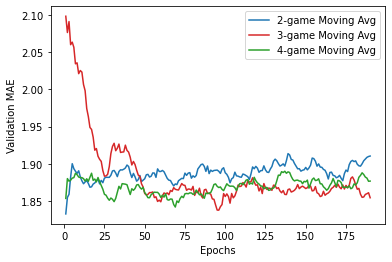

In [ ]:
smooth_mae_history_2 = smooth_curve(avg_mae_hist_2[10:])
smooth_mae_history_3 = smooth_curve(avg_mae_hist_3[10:])
smooth_mae_history_4 = smooth_curve(avg_mae_hist_4[10:])

plt.plot(range(1, len(smooth_mae_history_2) + 1), smooth_mae_history_2, label='2-game Moving Avg', color='tab:blue')
plt.plot(range(1, len(smooth_mae_history_3) + 1), smooth_mae_history_3, label='3-game Moving Avg', color='tab:red')
plt.plot(range(1, len(smooth_mae_history_4) + 1), smooth_mae_history_4, label='4-game Moving Avg', color='tab:green')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [ ]:
"""
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']

epochs = range(1, len(mae_values) + 1)

fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

color = 'tab:red'
axs[1].plot(epochs, loss_values, 'bo', label='Training', color=color)
axs[1].plot(epochs, val_loss_values, 'b', label='Validation', color=color)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

color = 'tab:blue'
axs[0].plot(epochs, mae_values, 'bo', label='Training', color=color)
axs[0].plot(epochs, val_mae_values, 'b', label='Validation', color=color)
axs[0].set_ylabel('MAE')
axs[0].legend()

plt.show()

np.mean(mae_values)
"""

"\nhistory_dict = history.history\n\nloss_values = history_dict['loss']\nval_loss_values = history_dict['val_loss']\nmae_values = history_dict['mae']\nval_mae_values = history_dict['val_mae']\n\nepochs = range(1, len(mae_values) + 1)\n\nfig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0})\n\ncolor = 'tab:red'\naxs[1].plot(epochs, loss_values, 'bo', label='Training', color=color)\naxs[1].plot(epochs, val_loss_values, 'b', label='Validation', color=color)\naxs[1].set_ylabel('Loss')\naxs[1].set_xlabel('Epochs')\naxs[1].legend()\n\ncolor = 'tab:blue'\naxs[0].plot(epochs, mae_values, 'bo', label='Training', color=color)\naxs[0].plot(epochs, val_mae_values, 'b', label='Validation', color=color)\naxs[0].set_ylabel('MAE')\naxs[0].legend()\n\nplt.show()\n\nnp.mean(mae_values)\n"

In [ ]:
"""
start = 1000
end = 1005
print(model.predict(train_df[start:end]))
print(train_targets[start:end])
"""

'\nstart = 1000\nend = 1005\nprint(model.predict(train_df[start:end]))\nprint(train_targets[start:end])\n'